In [24]:
import numpy as np
import time
import psutil
from scipy.linalg import lu_factor, lu_solve, ldl
from scipy.sparse import csc_matrix, bmat
from scipy.sparse.linalg import splu, spsolve
import matplotlib.pyplot as plt

# 1.3

# Equality Solver

In [25]:
def measure_cpu_usage(interval=1.0):
    return psutil.cpu_percent(interval=interval)

def EqualityQPSolverLUdense(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()
    
    n = H.shape[0]
    m = A.shape[1]
    KKT = np.block([
        [H, A],
        [A.T, np.zeros((m, m))]
    ])
    rhs = np.concatenate([-g, b])
    lu, piv = lu_factor(KKT)
    sol = lu_solve((lu, piv), rhs)
    x = sol[:n]
    lam = sol[n:]
    
    end_time = time.time()
    end_cpu = time.process_time()
    
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    
    return x, lam, elapsed_time, cpu_usage

def EqualityQPSolverLUsparse(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()
    
    n = H.shape[0]
    m = b.shape[0]
    Hs = csc_matrix(H)
    As = csc_matrix(A)
    KKT = bmat([
    [Hs, -As.T],
    [As, None]
], format='csc')
    rhs = np.concatenate([-g, b])
    lu = splu(KKT)
    sol = lu.solve(rhs)
    x = sol[:n]
    lam = sol[n:]
    
    end_time = time.time()
    end_cpu = time.process_time()
    
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    
    return x, lam, elapsed_time, cpu_usage

def EqualityQPSolverLDLdense(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()
    
    n = H.shape[0]
    m = A.shape[0]
    KKT = np.block([
        [H, -A.T],
        [A, np.zeros((m, m))]
    ])
    rhs = np.concatenate([-g, b])
    L, D, perm = ldl(KKT)
    y = np.linalg.solve(L, rhs[perm])
    z = np.linalg.solve(D, y)
    sol = np.linalg.solve(L.T, z)
    x = sol[:n]
    lam = sol[n:]
    
    end_time = time.time()
    end_cpu = time.process_time()
    
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    
    return x, lam, elapsed_time, cpu_usage

def EqualityQPSolverLDLsparse(H, g, A, b):
 #doesnt work
 return ('dosent work in python')

def EqualityQPSolverRangeSpace(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()
    
    # Range space method
    At = A.T
    S = A @ np.linalg.solve(H, At)
    rhs = b + A @ np.linalg.solve(H, g)
    lam = np.linalg.solve(S, rhs)
    x = -np.linalg.solve(H, g - At @ lam)
    
    end_time = time.time()
    end_cpu = time.process_time()
    
    elapsed_time = end_time - start_time
    cpu_time = end_cpu - start_cpu
    
    return x, lam, elapsed_time, cpu_time

def EqualityQPSolverNullSpace(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()
    
    # Null space method
    from scipy.linalg import null_space
    Z = null_space(A)
    x0 = np.linalg.lstsq(A, b, rcond=None)[0]
    Hz = Z.T @ H @ Z
    gz = Z.T @ (H @ x0 + g)
    p = -np.linalg.solve(Hz, gz)
    x = x0 + Z @ p
    lam = np.linalg.lstsq(A.T, H @ x + g, rcond=None)[0]
    
    end_time = time.time()
    end_cpu = time.process_time()
    
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    
    return x, lam, elapsed_time, cpu_usage

def EqualityQPSolver(H, g, A, b, solver):
    solvers = {
        "LUdense": EqualityQPSolverLUdense,
        "LUsparse": EqualityQPSolverLUsparse,
        "LDLdense": EqualityQPSolverLDLdense,
        "LDLsparse": EqualityQPSolverLDLsparse,
        "RangeSpace": EqualityQPSolverRangeSpace,
        "NullSpace": EqualityQPSolverNullSpace
    }
    if solver not in solvers:
        raise ValueError(f"Unknown solver: {solver}")
    return solvers[solver](H, g, A, b)


In [26]:
def generate_test_problem(n, beta, alpha):
    # Generate random matrix M with 15% nonzero elements
    M = np.random.randn(n, n)
    mask_M = np.random.rand(n, n) > 0.85
    M[mask_M] = 0
    
    # Generate H = M M' + alpha I
    H = M @ M.T + alpha * np.eye(n)
    
    # Generate random vector g
    g = np.random.randn(n)
    
    # Generate matrix A with 15% nonzero elements
    m = round(beta * n)
    A = np.random.randn(m, n)
    mask_A = np.random.rand(m, n) > 0.85
    A[mask_A] = 0

    # Transpose A so shape is (n × m), as expected by solver
    A = A.T
    
    # Generate random vector b
    b = np.random.randn(m)
    
    return H, g, A, b

def compute_lagrangian(H, g, A, b, x, lam):
    L = 0.5 * x.T @ H @ x + g.T @ x - np.dot(lam, (A.T @ x - b))
    return L


In [27]:
# Parameters
n = 100  # Size of x
beta = 0.5  # Ratio for size of A
alpha = 1.0 # Regularization parameter

# Generate test problem
np.random.seed(237)  # Set seed once, before generating data
H, g, A, b = generate_test_problem(n, beta, alpha)

# Print the variables, so it can be used in MatLab as well
print("x:", x)
print("lam:", lam)
print("A:", (A))
print("b:", b)

x: [ 0.14942249 -0.00586125  0.04829555 -0.07021552  0.03807089 -0.00532409
 -0.24651211  0.27968437  0.09039149  0.18194673  0.12850585 -0.40226687
 -0.09066253 -0.28873601 -0.09308505  0.10584299  0.14114747  0.05698179
  0.31395428  0.03230159 -0.0472302   0.05626482  0.2688706  -0.06376941
  0.30514453  0.12325484 -0.11111315 -0.12962575 -0.09905142 -0.08289109
  0.04740822 -0.06963854 -0.26996341 -0.10360359  0.35350272 -0.038412
  0.17838291  0.19606213  0.02219332 -0.1036406   0.12457081  0.04057032
 -0.04945967  0.07980445  0.10367323  0.05267071 -0.24201189 -0.33163025
 -0.16626331 -0.04338016  0.28463837  0.04553417  0.39393014 -0.0317796
  0.15577135  0.11231427 -0.07329468  0.04268089 -0.21504073  0.01965871
 -0.24303057  0.12504482  0.01636513  0.13271933 -0.03184817  0.04279165
 -0.31135864  0.10193769 -0.31187568 -0.00883788  0.00983664  0.25460181
  0.03836427  0.07749805  0.05104892  0.12473845 -0.44170602  0.06205612
  0.05548412  0.3722264   0.05633953  0.0025162   0

In [28]:
# x, lam, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LDLsparse')
# L = compute_lagrangian(H, g, A, b, x, lam)
# L, time1, cpu1 

In [29]:
x, lam, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LUdense')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the LU dense, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the LU dense, L: 50.7140, time1: 0.0273, cpu: 0.0112


In [30]:
x, lam, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LUsparse')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the LU sparse, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 50, expected 100.

In [ ]:
x, lam, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LDLdense')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the LDLdense, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the LDLdense, L: 233.3695, time1: 0.4834, cpu: 2.1556


In [ ]:
x, lam, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'RangeSpace')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the Range space, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the Range space, L: 233.3695, time1: 0.1361, cpu: 1.0068


In [ ]:
x, lam, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'NullSpace')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the NullSpace, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the NullSpace, L: 233.3695, time1: 0.8488, cpu: 6.3665


# 1.6

In [ ]:
def EqualityQPSolverLUdense(H, g, A, b):
    start = time.time()
    n = H.shape[0]
    m = A.shape[1]

    KKT = np.block([
        [H, A],
        [A.T, np.zeros((m, m))]
    ])
    rhs = -np.concatenate([g, b])
    sol = np.linalg.solve(KKT, rhs)

    x = sol[:n]
    lam = sol[n:]
    wall_time = time.time() - start
    cpu_time = time.process_time()
    return x, lam, wall_time, cpu_time

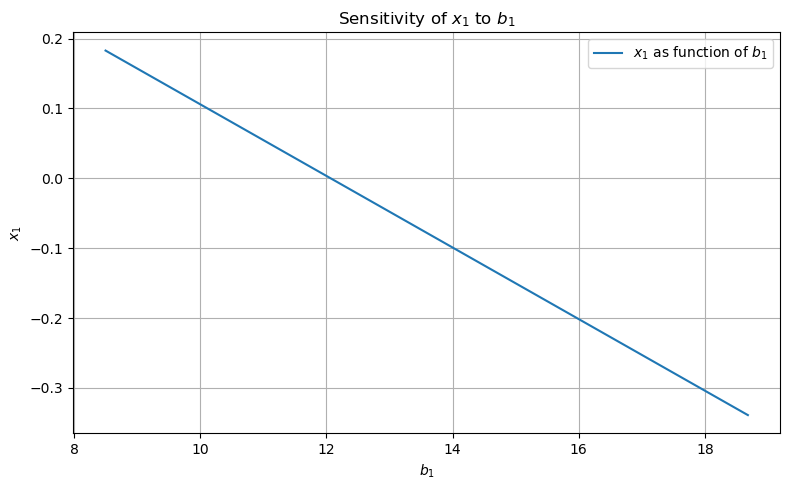

In [ ]:
# Parameters
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])

g = np.array([-16.1000, -8.5000, -15.7000, -10.0200, -18.6800])

A = np.array([
    [16.1000, 1.0000],
    [8.5000, 1.0000],
    [15.7000, 1.0000],
    [10.0200, 1.0000],
    [18.6800, 1.0000]
])

# Vary b[0] from 8.5 to 18.68
b1_values = np.linspace(8.5, 18.68, 100)
x1_values = []

for b1 in b1_values:
    b = np.array([b1, 1.0])
    x, _, _, _ = EqualityQPSolver(H, g, A, b, 'LUdense')  # Ignore extras if not needed
    x1_values.append(x[0])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(b1_values, x1_values, label=r'$x_1$ as function of $b_1$')
plt.xlabel(r'$b_1$')
plt.ylabel(r'$x_1$')
plt.title(r'Sensitivity of $x_1$ to $b_1$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
